In [269]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore #for standardization
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

## Overview

1.Read the problem statement.

2.Get the dataset.

3.Explore the dataset.

4.Pre-processing of dataset.

5.Visualization

6.Transform the dataset for building machine learning model.

7.Split data into train, test set.

7.Build Model.

8.Apply the model.

9.Evaluate the model.

10.Finding Optimal K value

11.Repeat 7,8,9 steps.

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Attributes of the dataset:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

## Question 1

Import the data set and print 10 random rows from the data set

In [270]:
data = pd.read_csv("iris.csv")
data.sample(10) #10 random rows

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
80,81,5.5,2.4,3.8,1.1,Iris-versicolor
112,113,6.8,3.0,5.5,2.1,Iris-virginica
19,20,5.1,3.8,1.5,0.3,Iris-setosa
27,28,5.2,3.5,1.5,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
109,110,7.2,3.6,6.1,2.5,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica
43,44,5.0,3.5,1.6,0.6,Iris-setosa
124,125,6.7,3.3,5.7,2.1,Iris-virginica
140,141,6.7,3.1,5.6,2.4,Iris-virginica


## Data Pre-processing

## Question 2 - Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [271]:
# to check nan values data.isna().sum()
data.fillna(data.median(), inplace=True) #Filling nan values with median

## Question 3 - Dealing with categorical data

Change all the classes to numericals (0to2).

In [272]:
species = {'Iris-virginica' : 0, 'Iris-versicolor' : 1 , 'Iris-setosa' : 2}
data['Species'] = [species[item] for item in data['Species']]
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,2
1,2,4.9,3.0,1.4,0.2,2
2,3,4.7,3.2,1.3,0.2,2
3,4,4.6,3.1,1.5,0.2,2
4,5,5.0,3.6,1.4,0.2,2


## Question 4

*Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [273]:
cor = data.corr()
cor

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,1.000000,0.702734,-0.392693,0.872346,0.890676,-0.942753
SepalLengthCm,0.702734,1.000000,-0.109369,0.871120,0.815986,-0.775061
SepalWidthCm,-0.392693,-0.109369,1.000000,-0.420713,-0.356510,0.417318
PetalLengthCm,0.872346,0.871120,-0.420713,1.000000,0.962043,-0.944477
PetalWidthCm,0.890676,0.815986,-0.356510,0.962043,1.000000,-0.952513
Species,-0.942753,-0.775061,0.417318,-0.944477,-0.952513,1.000000


In [274]:
droppedCol = []
for col in data.columns:
    if (col != 'Species'):
        corr = data[col].corr(data['Species']) 
        if (corr >= -0.1 and corr <= 0.1):
            droppedCol.append(col)
droppedCol
data.drop(droppedCol, inplace=True)

## Question 5

*Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [275]:
data.var()

Id               1938.000000
SepalLengthCm       0.676645
SepalWidthCm        0.185552
PetalLengthCm       3.076516
PetalWidthCm        0.577141
Species             0.675322
dtype: float64

In [276]:
data.drop(data.columns[data.apply(lambda col: col.var() < 0.1)],inplace=True)

## Question 6

*Plot the scatter matrix for all the variables.*

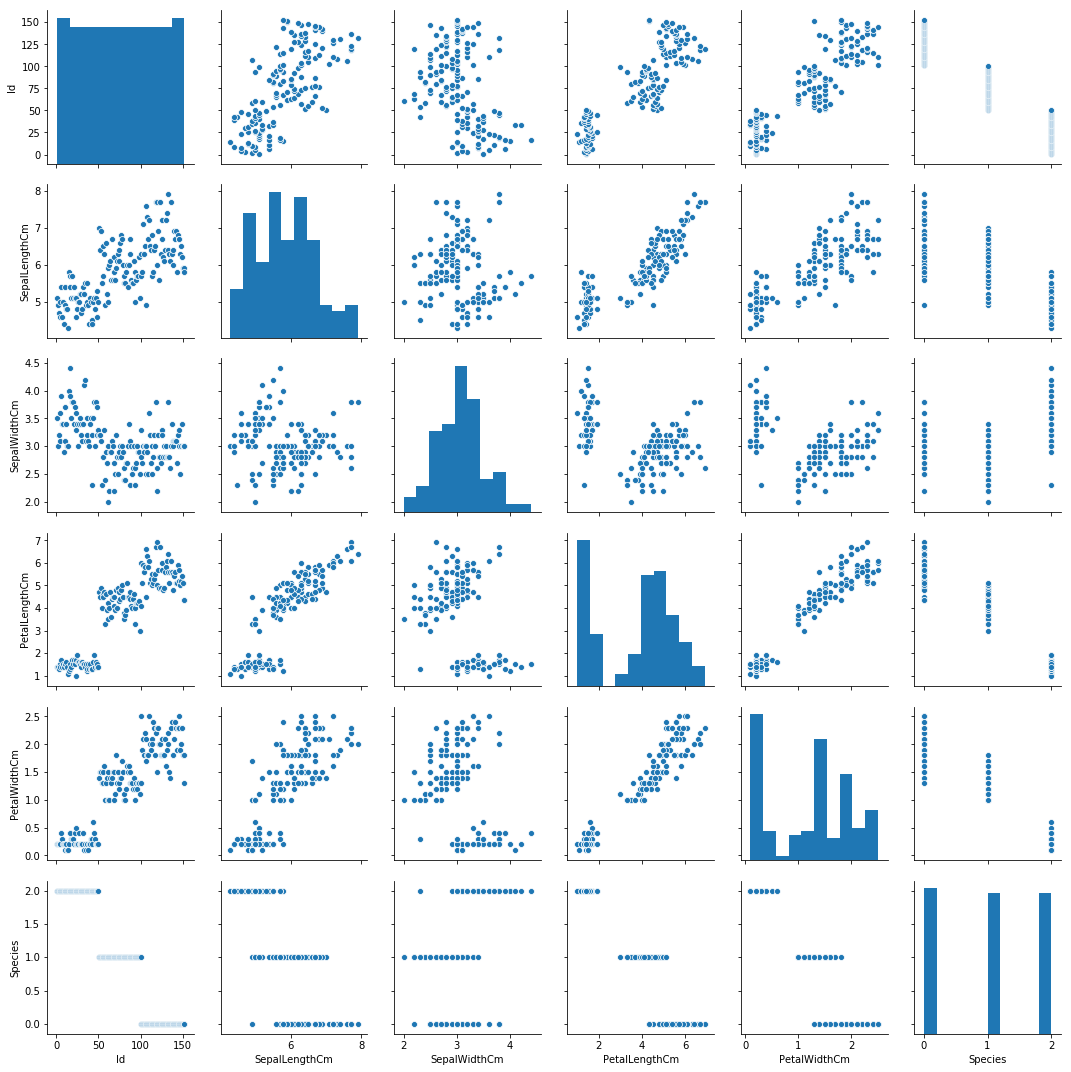

In [277]:
sns.pairplot(data)

## Split the dataset into training and test sets

## Question 7

*Split the dataset into training and test sets with 80-20 ratio.*

In [278]:
from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(data.drop(['Id','Species'], axis=1), data['Species'],test_size=0.2)

## Question 8 - Model

*Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

**Hint:** For accuracy you can check **accuracy_score()** in scikit-learn

In [279]:
def accuracy(k):
    NNH = KNeighborsClassifier(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
    model = NNH.fit(X_Train, Y_Train)
    Y_Pred = model.predict(X_Test)
    return accuracy_score(Y_Test, Y_Pred)


In [280]:
print("Model Accuracy for k = %d is %.2f"%(3, accuracy(3)))
print("Model Accuracy for k = %d is %.2f"%(5, accuracy(5)))
print("Model Accuracy for k = %d is %.2f"%(9, accuracy(9)))

Model Accuracy for k = 3 is 0.94
Model Accuracy for k = 5 is 0.94
Model Accuracy for k = 9 is 0.90


## Question 9 - Finding Optimal value of k.

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Miss classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

In [281]:
k_Values = np.arange(1,21,2)
mse_Values = []
for k in k_Values:
    mse = 1-accuracy(k)
    mse_Values.append(mse)
    print("MSE for k = %d is %.2f"%(k, mse))

MSE for k = 1 is 0.10
MSE for k = 3 is 0.06
MSE for k = 5 is 0.06
MSE for k = 7 is 0.10
MSE for k = 9 is 0.10
MSE for k = 11 is 0.10
MSE for k = 13 is 0.10
MSE for k = 15 is 0.10
MSE for k = 17 is 0.10
MSE for k = 19 is 0.10


## Question 10

*Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

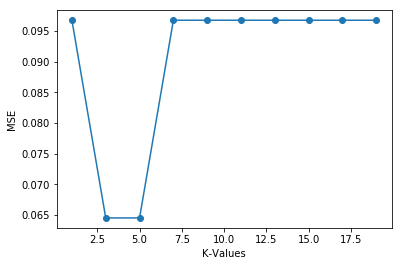

In [282]:
import matplotlib.pyplot as plt
plt.plot(k_Values,mse_Values,'o-')
plt.xlabel('K-Values')
plt.ylabel('MSE')
plt.show()

### Question 11: Read the data given in bc2.csv file

### Question 12: Observe the no.of records in dataset and type of each feature 

### Question 13: Use summary statistics to check if missing values, outlier and encoding treament is necessary

### Check Missing Values

### Question 14: Check how many `?` there in Bare Nuclei feature (they are also unknown or missing values). Replace them with the top value of the describe function of Bare Nuclei feature.

#### Check include='all' parameter in describe function

### Question 15: Find the distribution of target variable (Class) 

#### Plot the distribution of target variable using histogram

### convert the datatype of Bare Nuclei to `int`

### Question 16: Standardization of Data

### Question 17: Plot Scatter Matrix to understand the distribution of variables and check if any variables are collinear and drop one of them.

### Question 18: Divide the dataset into feature set and target set

### Divide the Training and Test sets in 70:30 

## Question 19 - Finding Optimal value of k

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Mis classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

### Question 20: Print the optimal number of neighbors